In [13]:
import copy
import time
import sys
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [14]:
# How many parameters are there?
num_params = 2
np.random.seed = 0

# Load the data
data = np.loadtxt('data.txt')
N = data.shape[0]

jump_sizes = np.array([0.01, 2.])

def from_prior():                      # Taking uniform priors for m and c, m ~ U[0, 1] and c ~ U[0, 10]
    
    m = rng.rand()
    c = 10*rng.rand()

    return np.array([m, c])


def log_prior(params):
    
    m, c = params[0], params[1]
    
    if m < 0. or m > 1.0:
        return -np.Inf
    if c < 0. or c > 10.:
        return -np.Inf
    return 0.


def log_likelihood(params):
    
    m, c = params[0], params[1]
    model = m * data[:,0] + c
    
    return -0.5 * np.sum((data[:,1] - model) ** 2 / data[:,2] ** 2 + np.log(2*np.pi*data[:,2]**2))

def logsumexp(values):
    
    if(values[0] > values[1]):
        result = values[0] + np.log(1+np.exp(values[1]-values[0]))
    else:
        result = values[1] + np.log(1+np.exp(values[0]-values[1]))
    # print((np.exp(values[0]) + np.exp(values[1])))
    # result = np.log(np.exp(values[0]) + np.exp(values[1]))
    
    return result

In [15]:
n_live = 100
live_points = np.zeros((n_live,2))
logp = np.zeros(n_live)
logl = np.zeros(n_live)

for i in range(0, n_live): 
    x = from_prior()
    live_points[i,:] = x
    logl[i] = log_likelihood(x)

steps = 2000

keep = np.zeros((steps, num_params + 4))

logL = []
logX = [0]
logZ = [-sys.float_info.max]
logw = []

start = time.time()
for i in range(steps):
    
    worst = int(np.where(logl == logl.min())[0][0])
    logL.append(logl[worst])
    logX.append(-(i+1)/n_live)
    logw.append(np.log(np.exp(-i/n_live) - np.exp(-(i+1)/n_live)))
    values = np.array([logZ[i], logL[i]+logw[i]])
    logZ.append(logsumexp(values))
  
    # which = rng.randint(n_live)
    # while which == worst:
    #     which = rng.randint(n_live)
    # live_points[worst] = copy.deepcopy(live_points[which])
    
    threshold = copy.deepcopy(logl[worst])
    
    keep[i, :2] = live_points[worst]
    keep[i, 2:6] = logL[i], logX[i+1], logw[i], logZ[i+1]
    

    for j in range(10000):
        
        new = from_prior()
        logp_new = log_prior(new)
        
        # Only evaluate likelihood if prior prob isn't zero [log(prior) is not -infinity].
        logl_new = -np.Inf
        
        if(logp_new != -np.Inf):
            
            logl_new = log_likelihood(new)
            
        if (logl_new >= threshold):
            
            live_points[worst] = new
            logp[worst] = logp_new
            logl[worst] = logl_new
            break 
                  
end = time.time()
print('time taken: {} minutes'.format((end-start)/60.))

time taken: 5.224639427661896 minutes


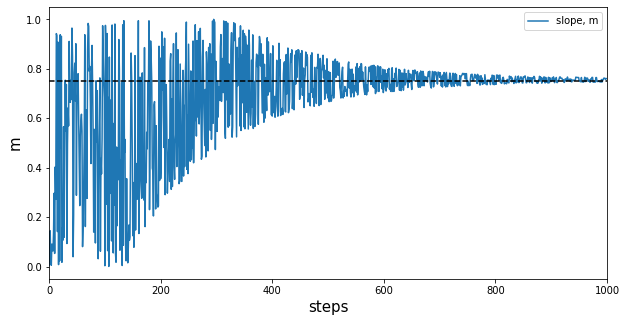

In [16]:
plt.figure(figsize=(10,5))

plt.plot(keep[:,0], label = "slope, m")
plt.axhline(y=0.75, ls='--', color='k')
plt.xlabel("steps", fontsize = '15')
plt.ylabel("m", fontsize = '15')
plt.xlim(0,1000)
plt.legend()
plt.show()

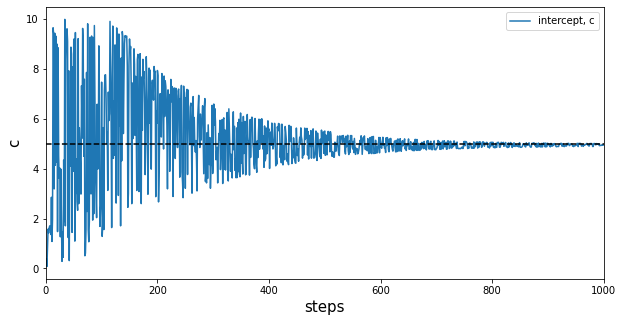

In [17]:
plt.figure(figsize=(10,5))

plt.plot(keep[:,1], label = "intercept, c")
plt.axhline(y=5., ls='--', color='k')
plt.xlabel("steps", fontsize = '15')
plt.ylabel("c", fontsize = '15')
plt.xlim(0,1000)
plt.legend()
plt.show()

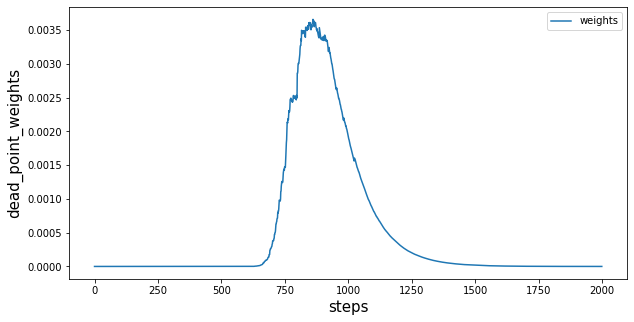

In [18]:
log_Likelihood = np.array(logL)
log_w_i = np.array(logw)
logwt = log_Likelihood + log_w_i
log_evidence = np.array(logZ)

weights = np.exp(logwt - log_evidence[-1])


plt.figure(figsize=(10,5))


plt.plot(weights, label = "weights")
plt.xlabel("steps", fontsize = '15')
plt.ylabel("dead_point_weights", fontsize = '15')
plt.legend()
plt.show()

In [26]:
weights.shape

(2000,)

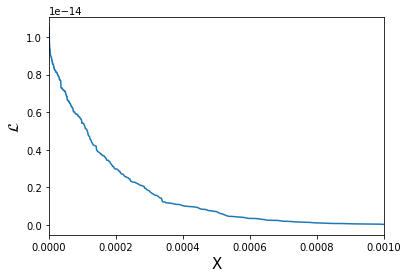

In [19]:
plt.plot(np.exp(keep[:,3]), np.exp(keep[:,2]))
plt.xlabel("X", fontsize = '15')
plt.ylabel(r'$\mathcal{L}$', fontsize = '15')
plt.xlim(0, 0.001)
plt.show()

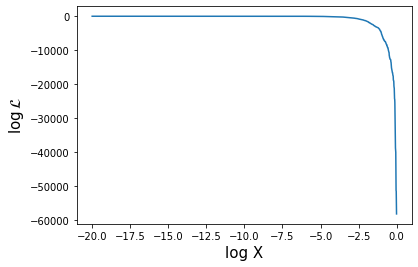

In [20]:
plt.plot(keep[:,3], keep[:,2])
plt.xlabel("log X", fontsize = '15')
plt.ylabel(r'$\log\mathcal{L}$', fontsize = '15')
# plt.xlim(0,0.002)
plt.show()

In [36]:
weightedSamples1 = np.array([])
weightedSamples2 = np.array([])
for i in range(steps):
    weightedSamples1 = np.append(weightedSamples1, weights[i] * keep[i, 0])
    weightedSamples2 = np.append(weightedSamples2, weights[i] * keep[i, 1])

In [37]:
weightedSamples1.shape

(2000,)

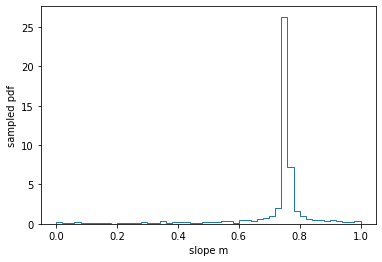

In [21]:
plt.hist(keep[:,0], bins = 50, histtype = 'step', density ="True")
plt.xlabel("slope m")
plt.ylabel("sampled pdf")
plt.show()

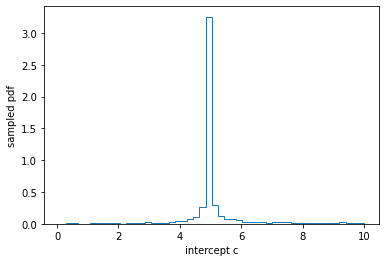

In [22]:
plt.hist(keep[:,1], bins = 50, histtype = 'step', density ="True")
plt.xlabel("intercept c")
plt.ylabel("sampled pdf")
plt.show()

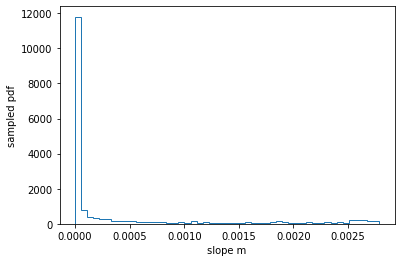

In [38]:
plt.hist(weightedSamples1[:], bins = 50, histtype = 'step', density ="True")
plt.xlabel("slope m")
plt.ylabel("sampled pdf")
plt.show()

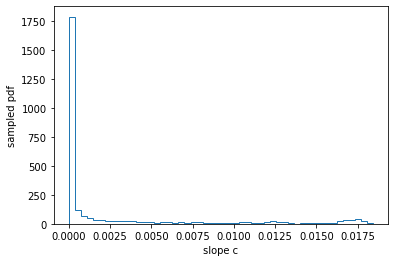

In [40]:
plt.hist(weightedSamples2[:], bins = 50, histtype = 'step', density ="True")
plt.xlabel("slope c")
plt.ylabel("sampled pdf")
plt.show()

In [23]:
samples = np.empty((steps, 2))
samples[:, 0] = keep[:, 0]
samples[:, 1] = keep[:, 1]

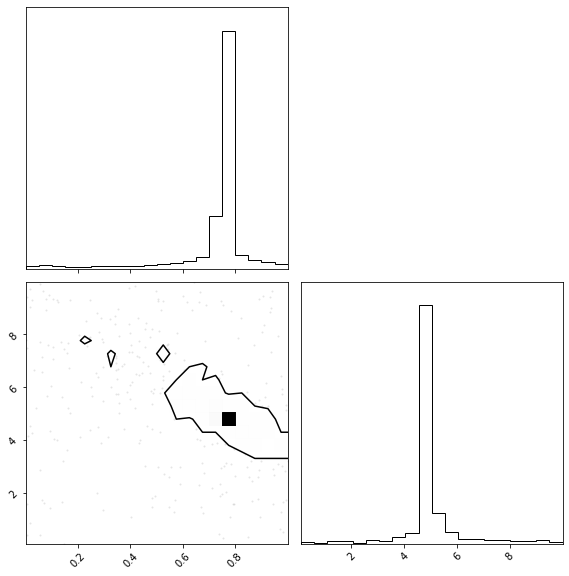

In [24]:
import corner
figure = corner.corner(samples)
labels = ["slope m", "intercept c"]

figure.set_size_inches(10, 10, forward=True)

In [25]:
a = []
a.append([1,2,3])
a

[[1, 2, 3]]